<a href="https://colab.research.google.com/github/shyapple1203/Advanced_Proteomics/blob/main/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from requests import get

# comet
name = ['blue','green','red','yellow']
for n  in name:
    for i in range(1,4):
        url = 'https://pub.taejoonlab.org/BME603/ABRF_iPRG2009/comet/iPRG2009_ECOLI_'+n+'_'+str(i)+'.iPRG2019_Study.comet.psms_pout.txt'
        file_name = url.split('/')[-1]
        with open(file_name, "wb") as file:   
            response = get(url)               
            file.write(response.content)

yr = ['red','yellow']
for n in yr:
    for i in range(4,6):
        url = 'https://pub.taejoonlab.org/BME603/ABRF_iPRG2009/comet/iPRG2009_ECOLI_'+n+'_'+str(i)+'.iPRG2019_Study.comet.psms_pout.txt'
        file_name = url.split('/')[-1]
        with open(file_name, "wb") as file:   
            response = get(url)               
            file.write(response.content)            

In [1]:
import gzip
import csv
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!curl -O https://pub.taejoonlab.org/BME603/ABRF_iPRG2009/db/iPRG2009_Study.MW.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86537  100 86537    0     0  59680      0  0:00:01  0:00:01 --:--:-- 59639


In [3]:
iPRG_MW = pd.read_csv('./iPRG2009_Study.MW.csv')
iPRG_MW.set_index('proteinIds', inplace = True)
iPRG_MW = iPRG_MW.astype({'mw':'float'}) 

In [ ]:
# Comet

Colors = ['red', 'yellow', 'green', 'blue']
CNumber = [5,5,3,3]
Mean_RYc = df()
Mean_Gc = df()
Mean_Bc = df()

for order, color in enumerate(Colors):
    countdf = df()

    for i in range(1,CNumber[order]+1):
        data = []
        filename = "./iPRG2009_ECOLI_"+color+"_"+str(i)+".iPRG2019_Study.comet.psms_pout.txt"
        f = open(filename, "rt")
        reader = csv.reader(f, delimiter='\t')
        data = list(reader)
        data_list = df(data[1:])
        data_list = data_list.iloc[:,:6]
        data_list.columns = data[0]
        f.close()

        data_list = data_list.astype({'q-value':'float', 'posterior_error_prob':'float', 'score':'float'}) 

        CNTM = []
        for p in data_list['proteinIds']:
            CNTM.append(p.find('Cntm_'))
        data_list['isCNTM'] = CNTM
        data_list.drop(data_list[data_list['isCNTM'] != -1].index, inplace = True)

        data_cut = data_list[data_list['q-value'] < 0.05]
        data_group = data_cut.groupby('proteinIds')

        cnt = df(data_group.count().iloc[:,0]).transpose()
        cnt.index = [str(i)]
        if i == 1 : countdf = cnt
        else: countdf = countdf.append(cnt)

    countdf = countdf.fillna(0)
    if order == 0: Mean_RYc =  df(countdf.mean()).transpose()
    elif order == 1: Mean_RYc = Mean_RYc.append(df(countdf.mean()).transpose())
    elif order == 2: Mean_Gc = df(countdf.mean())
    elif order == 3: Mean_Bc = df(countdf.mean())
        
Mean_Gc.columns = ['green']
Mean_Bc.columns = ['blue']        

Mean_RYc = Mean_RYc.transpose().fillna(0)
Mean_RYc.columns = ['red', 'yellow']

red_yel_Diff_c = df(Mean_RYc['red']-Mean_RYc['yellow'])
red_yel_Diff_c.columns = ['Difference']
red_yel_Diff_c_copy = red_yel_Diff_c.copy()

In [ ]:
standard = 5
for ind, diff in enumerate(red_yel_Diff_c['Difference']):
    if Mean_RYc['red'][ind] >= standard and Mean_RYc['yellow'][ind] >= standard:
        red_yel_Diff_c.iloc[ind] = 0

In [ ]:
blue_estc = red_yel_Diff_c[red_yel_Diff_c['Difference'] > 2]
green_estc = red_yel_Diff_c[red_yel_Diff_c['Difference'] < -2]

green_truec = Mean_Gc[Mean_Gc['green'] > 1]
blue_truec = Mean_Bc[Mean_Bc['blue'] > 1]

In [ ]:
list_blue_truec = list(blue_truec.index)
true_blue_cntc = 0;

for est in list(blue_estc.index):
    if est in list_blue_truec: true_blue_cntc += 1

print(true_blue_cntc)
print(len(blue_estc))
print(len(list_blue_truec))

42
55
258


In [ ]:
list_green_truec = list(green_truec.index)
true_green_cntc = 0;

for est in list(green_estc.index):
    if est in list_green_truec: true_green_cntc += 1

print(true_green_cntc)
print(len(green_estc))
print(len(list_green_truec))

48
49
251


In [ ]:
list_green_estc = list(green_truec.index)
overlap_cntc = 0;

for est in list(blue_truec.index):
    if est in list_green_estc: overlap_cntc += 1

print(overlap_cntc)

86


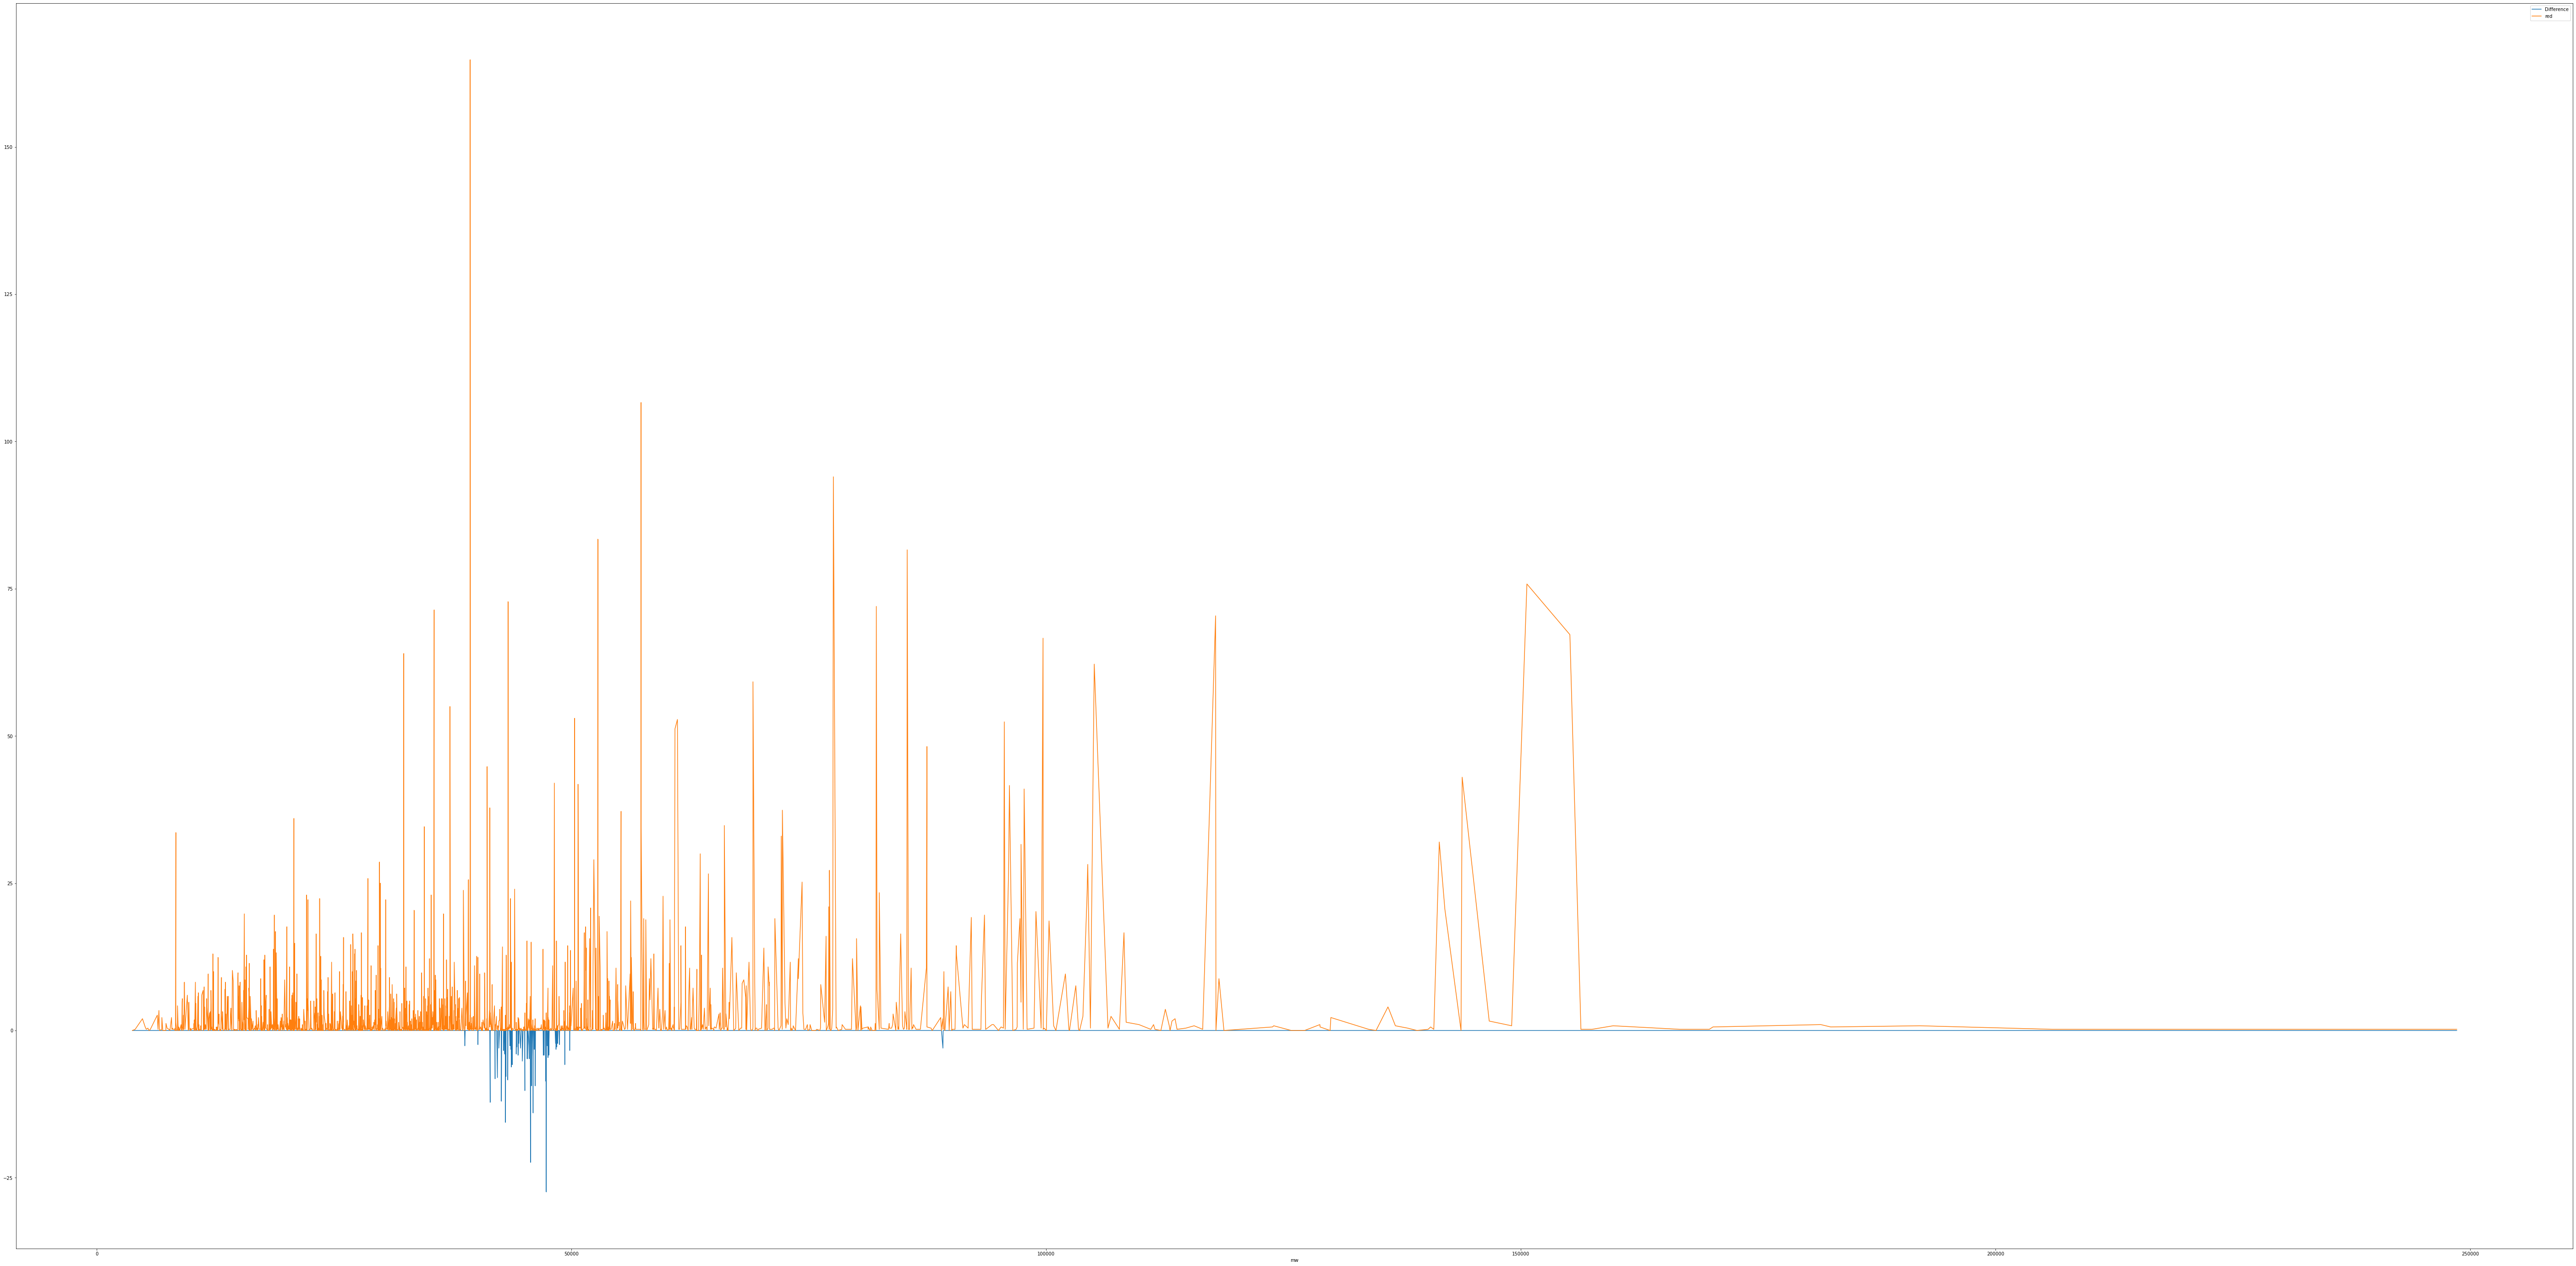

In [ ]:
Mean_Rcm = df(Mean_RYc['red']).transpose()
Mean_Rcm = Mean_Rcm.append(iPRG_MW.transpose()).dropna(axis = 1).transpose().set_index('mw').transpose()
Mean_Gcm = green_estc.transpose().append(iPRG_MW.transpose()).dropna(axis = 1).transpose().set_index('mw').transpose()

Mean_RGc_mw = Mean_Gcm.append(Mean_Rcm).transpose()
Mean_RGc_mw = Mean_RGc_mw.fillna(0)

# sns.lineplot(data = Mean_Rt.transpose(), x = 'mw', y = ['red', 'yellow'])
# plt.show()
Mean_RGc_mw.plot()
plt.rcParams["figure.figsize"] = (100,50)
plt.show()

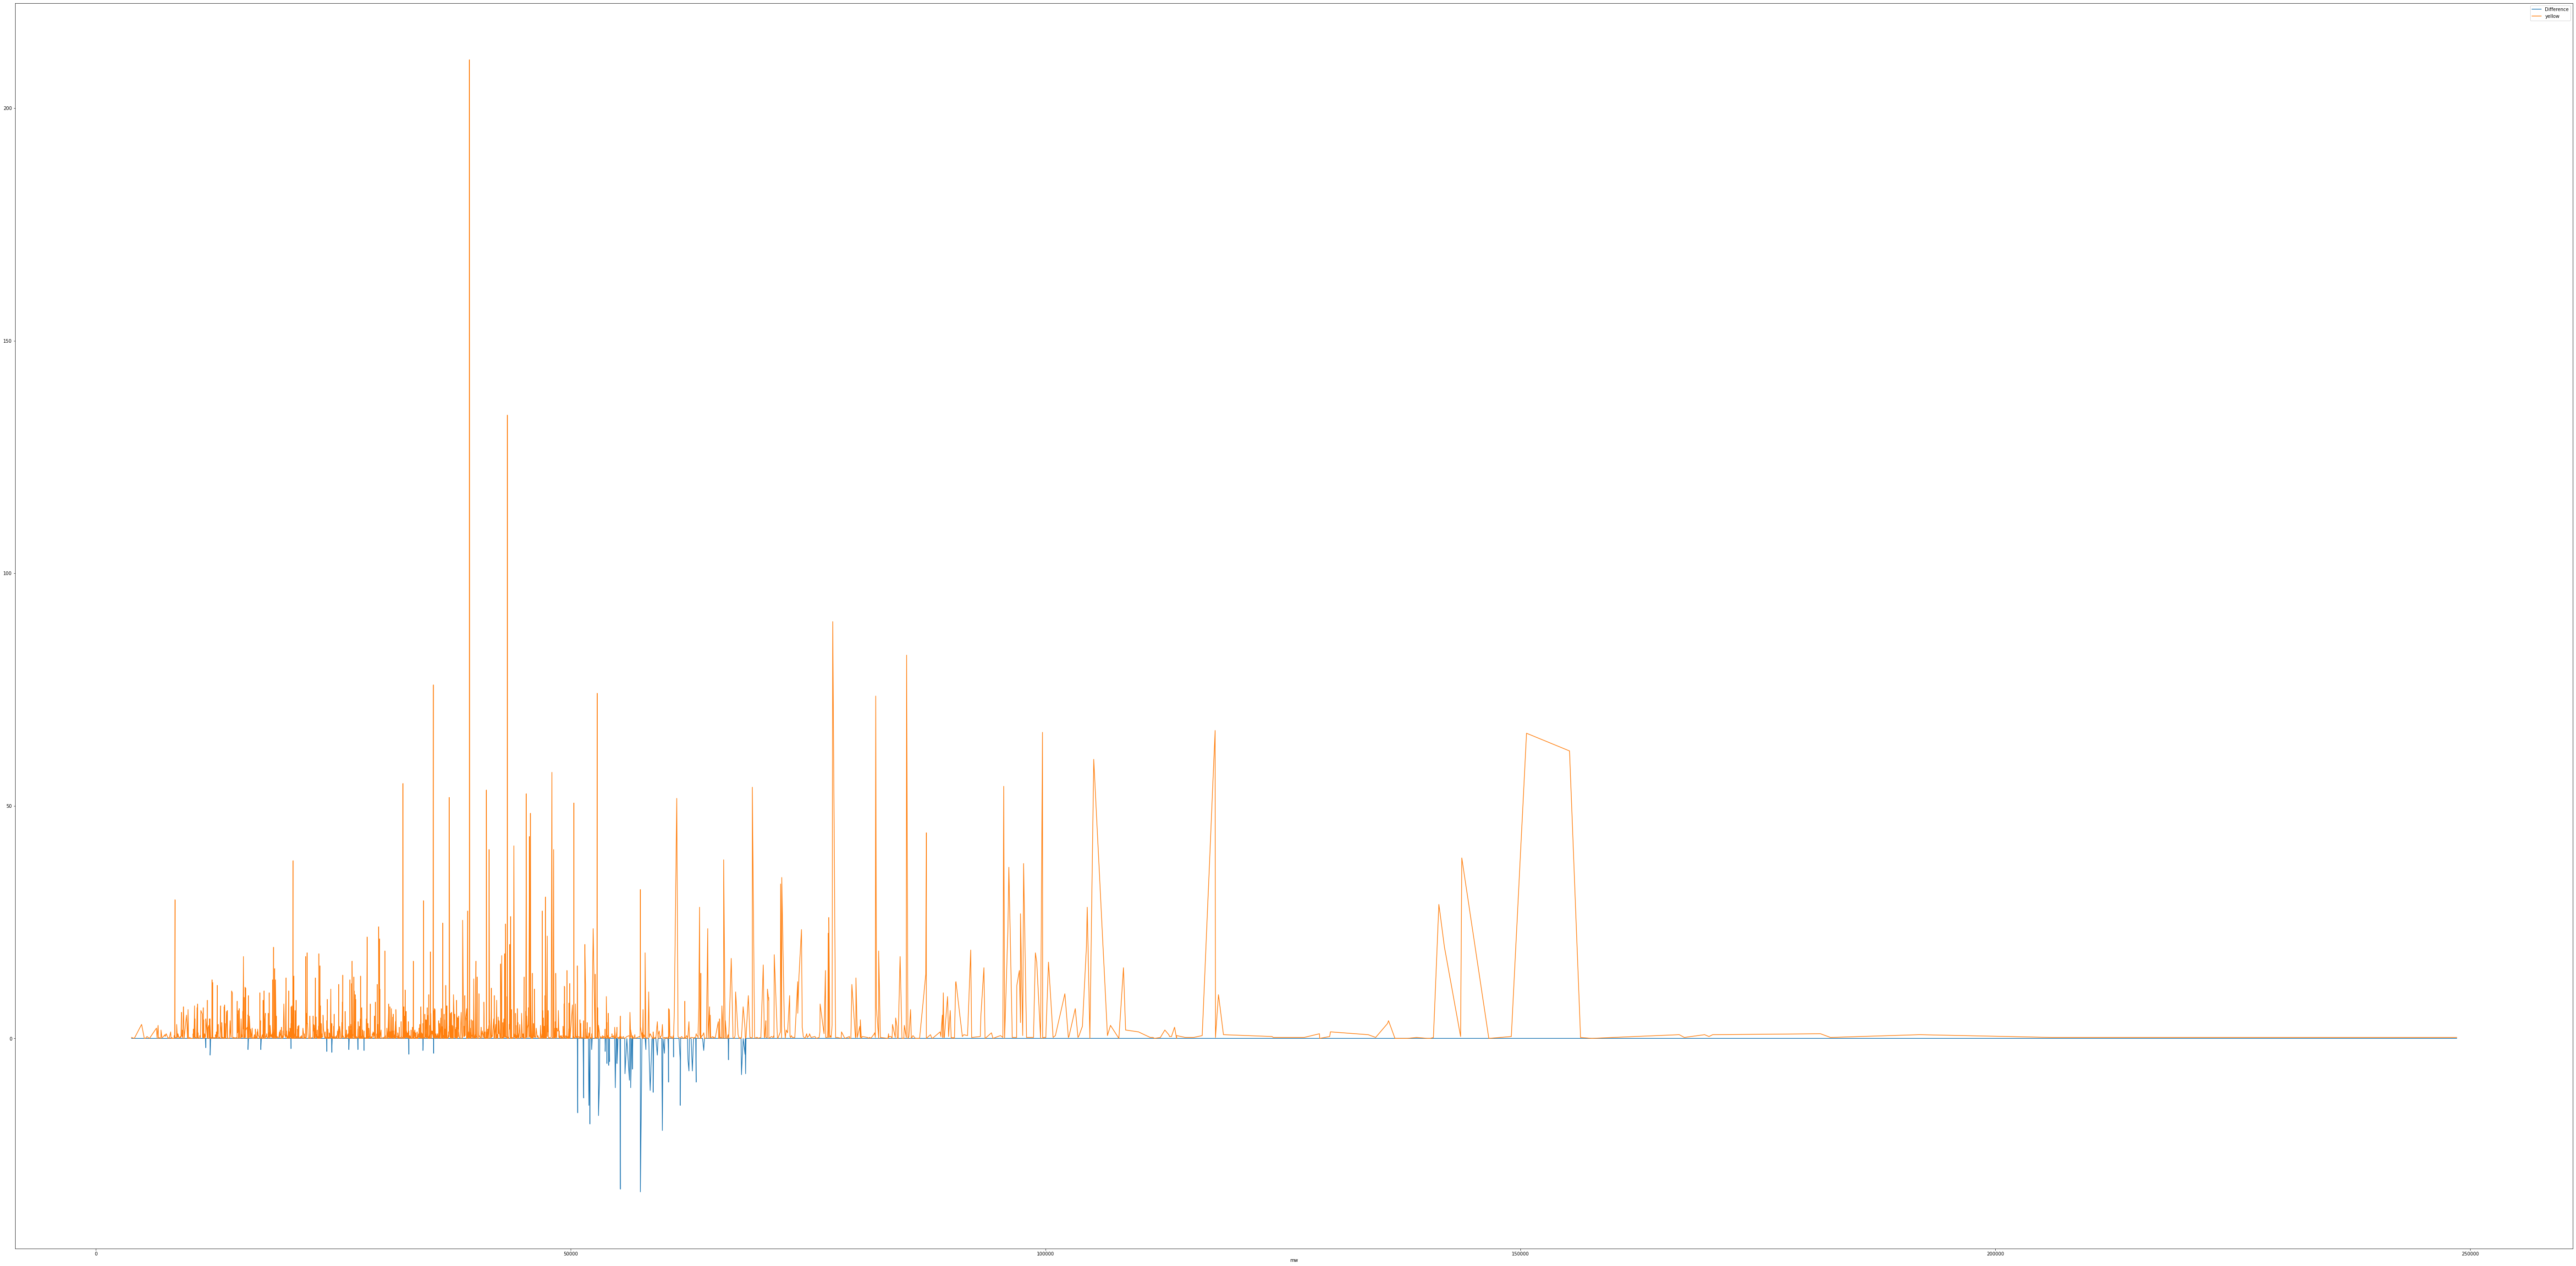

In [ ]:
Mean_Ycm = df(Mean_RYc['yellow']).transpose()
Mean_Ycm = Mean_Ycm.append(iPRG_MW.transpose()).dropna(axis = 1).transpose().set_index('mw').transpose()
Mean_Bcm = -blue_estc.transpose().append(iPRG_MW.transpose()).dropna(axis = 1).transpose().set_index('mw').transpose()

Mean_YBc_mw = Mean_Bcm.append(Mean_Ycm).transpose()
Mean_YBc_mw = Mean_YBc_mw.fillna(0)

Mean_YBc_mw.plot()
plt.rcParams["figure.figsize"] = (100,50)
plt.show()

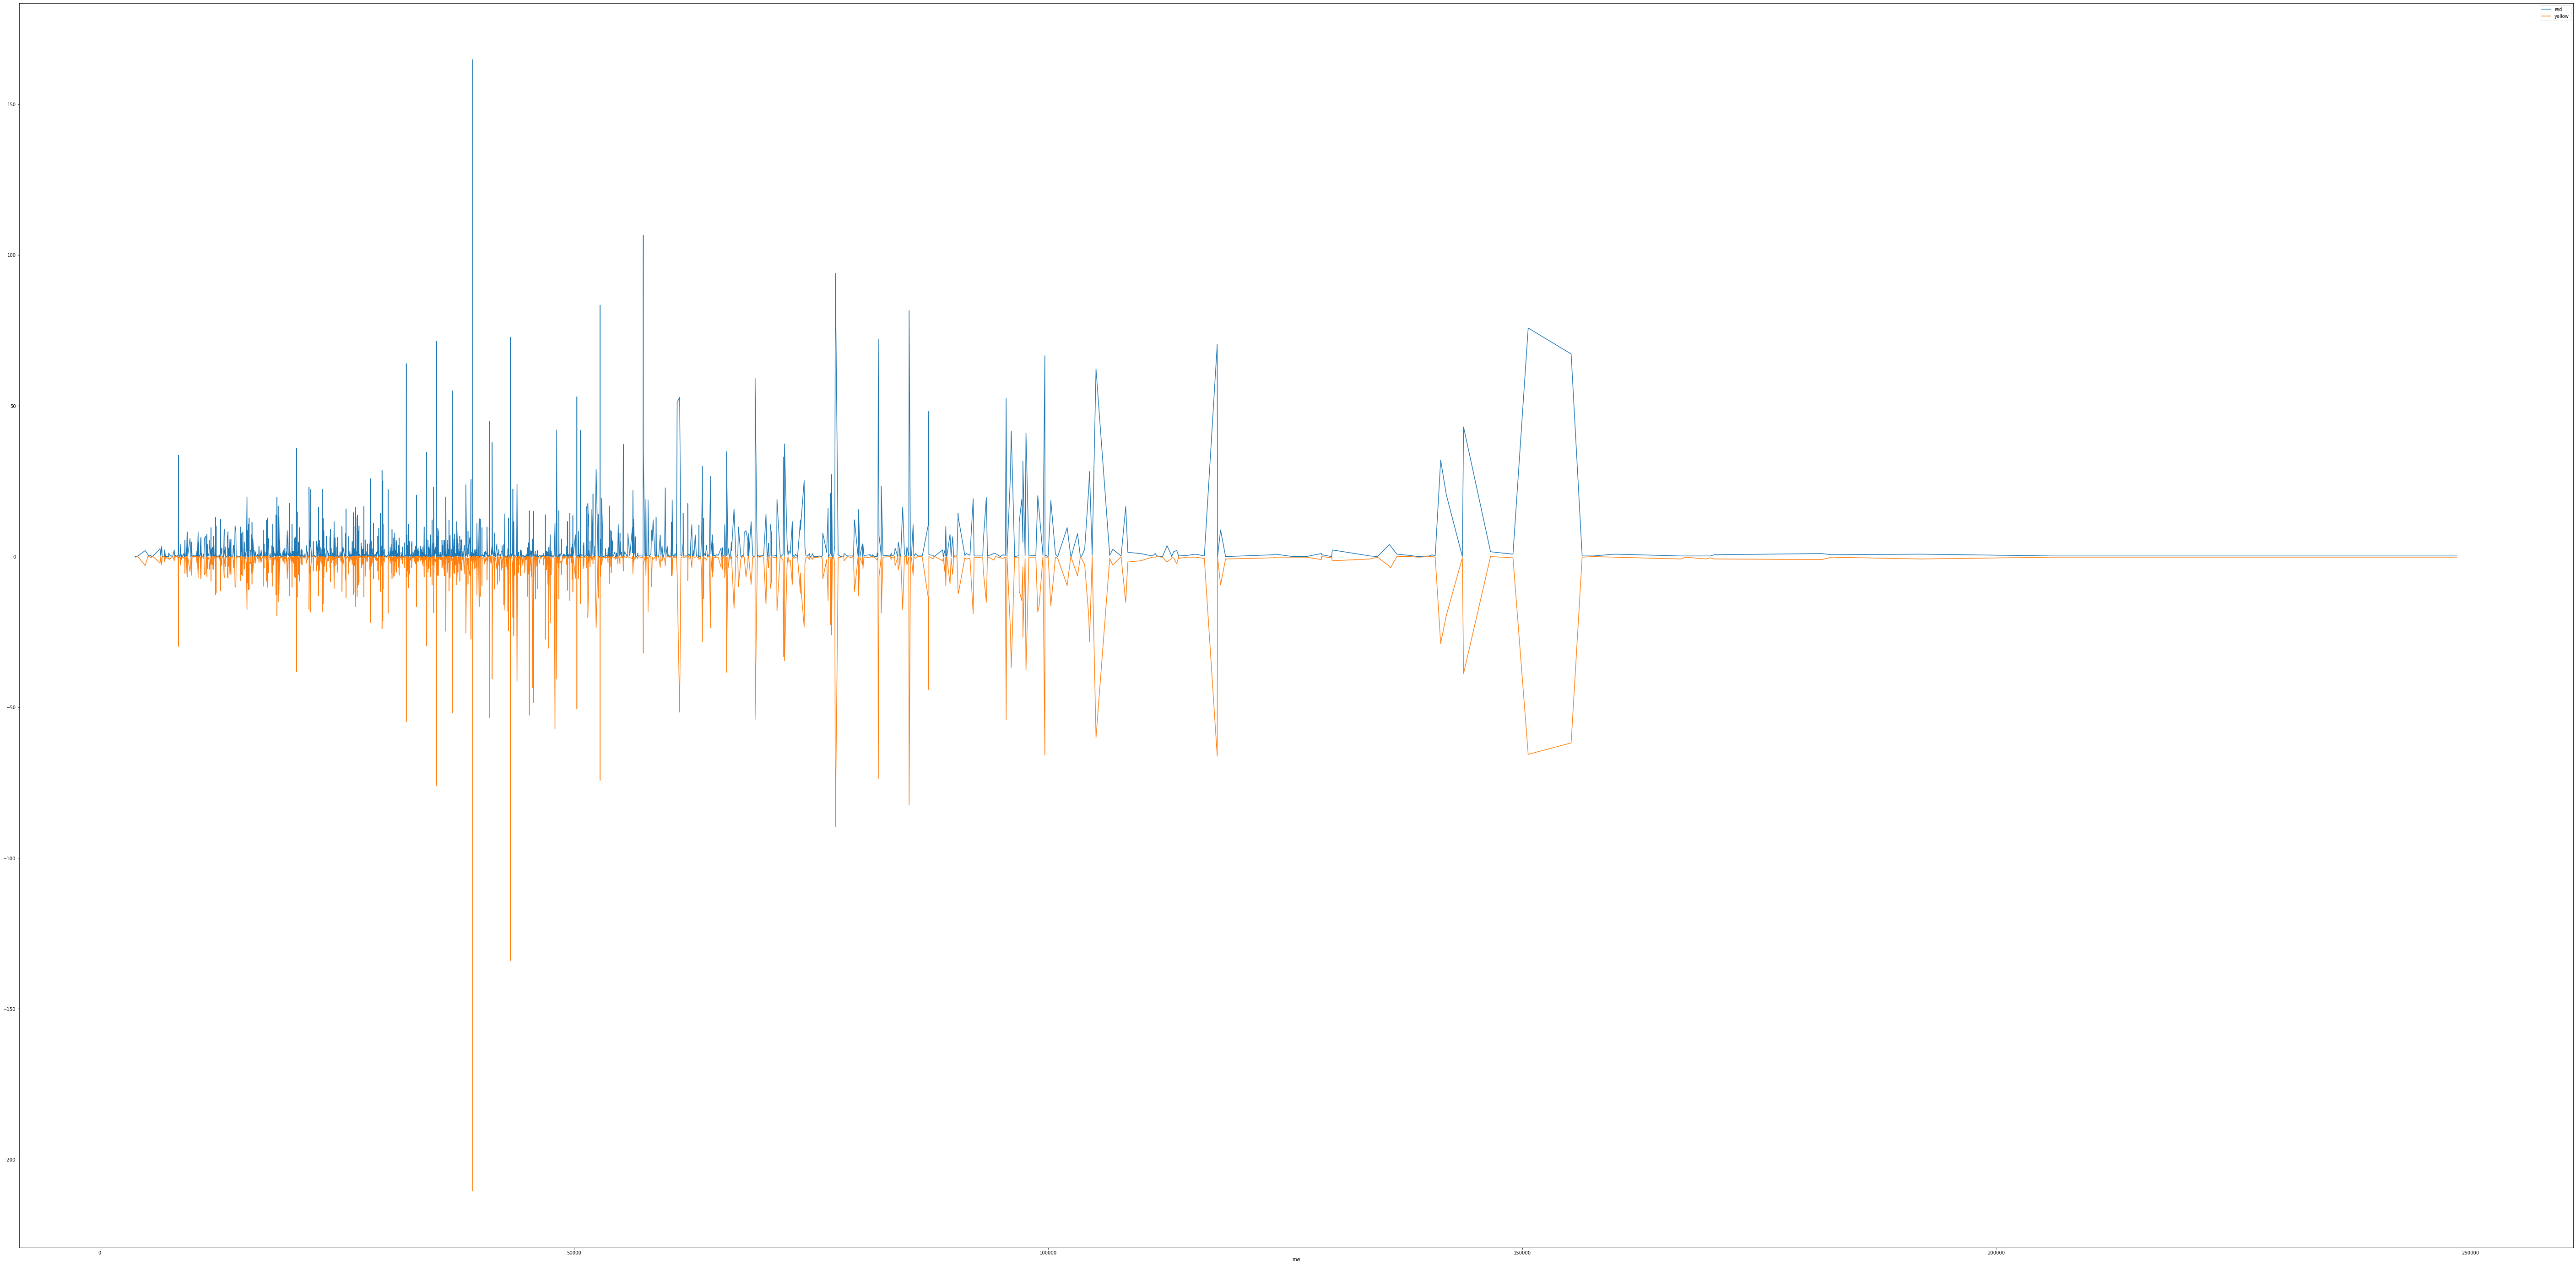

In [ ]:
Mean_RYc_mw = Mean_Rcm.append(-Mean_Ycm).transpose()
Mean_RYc_mw = Mean_RYc_mw.fillna(0)
Mean_RYc_mw.sort_index(inplace = True)

Mean_RYc_mw.plot()
plt.rcParams["figure.figsize"] = (100,50)
plt.show()

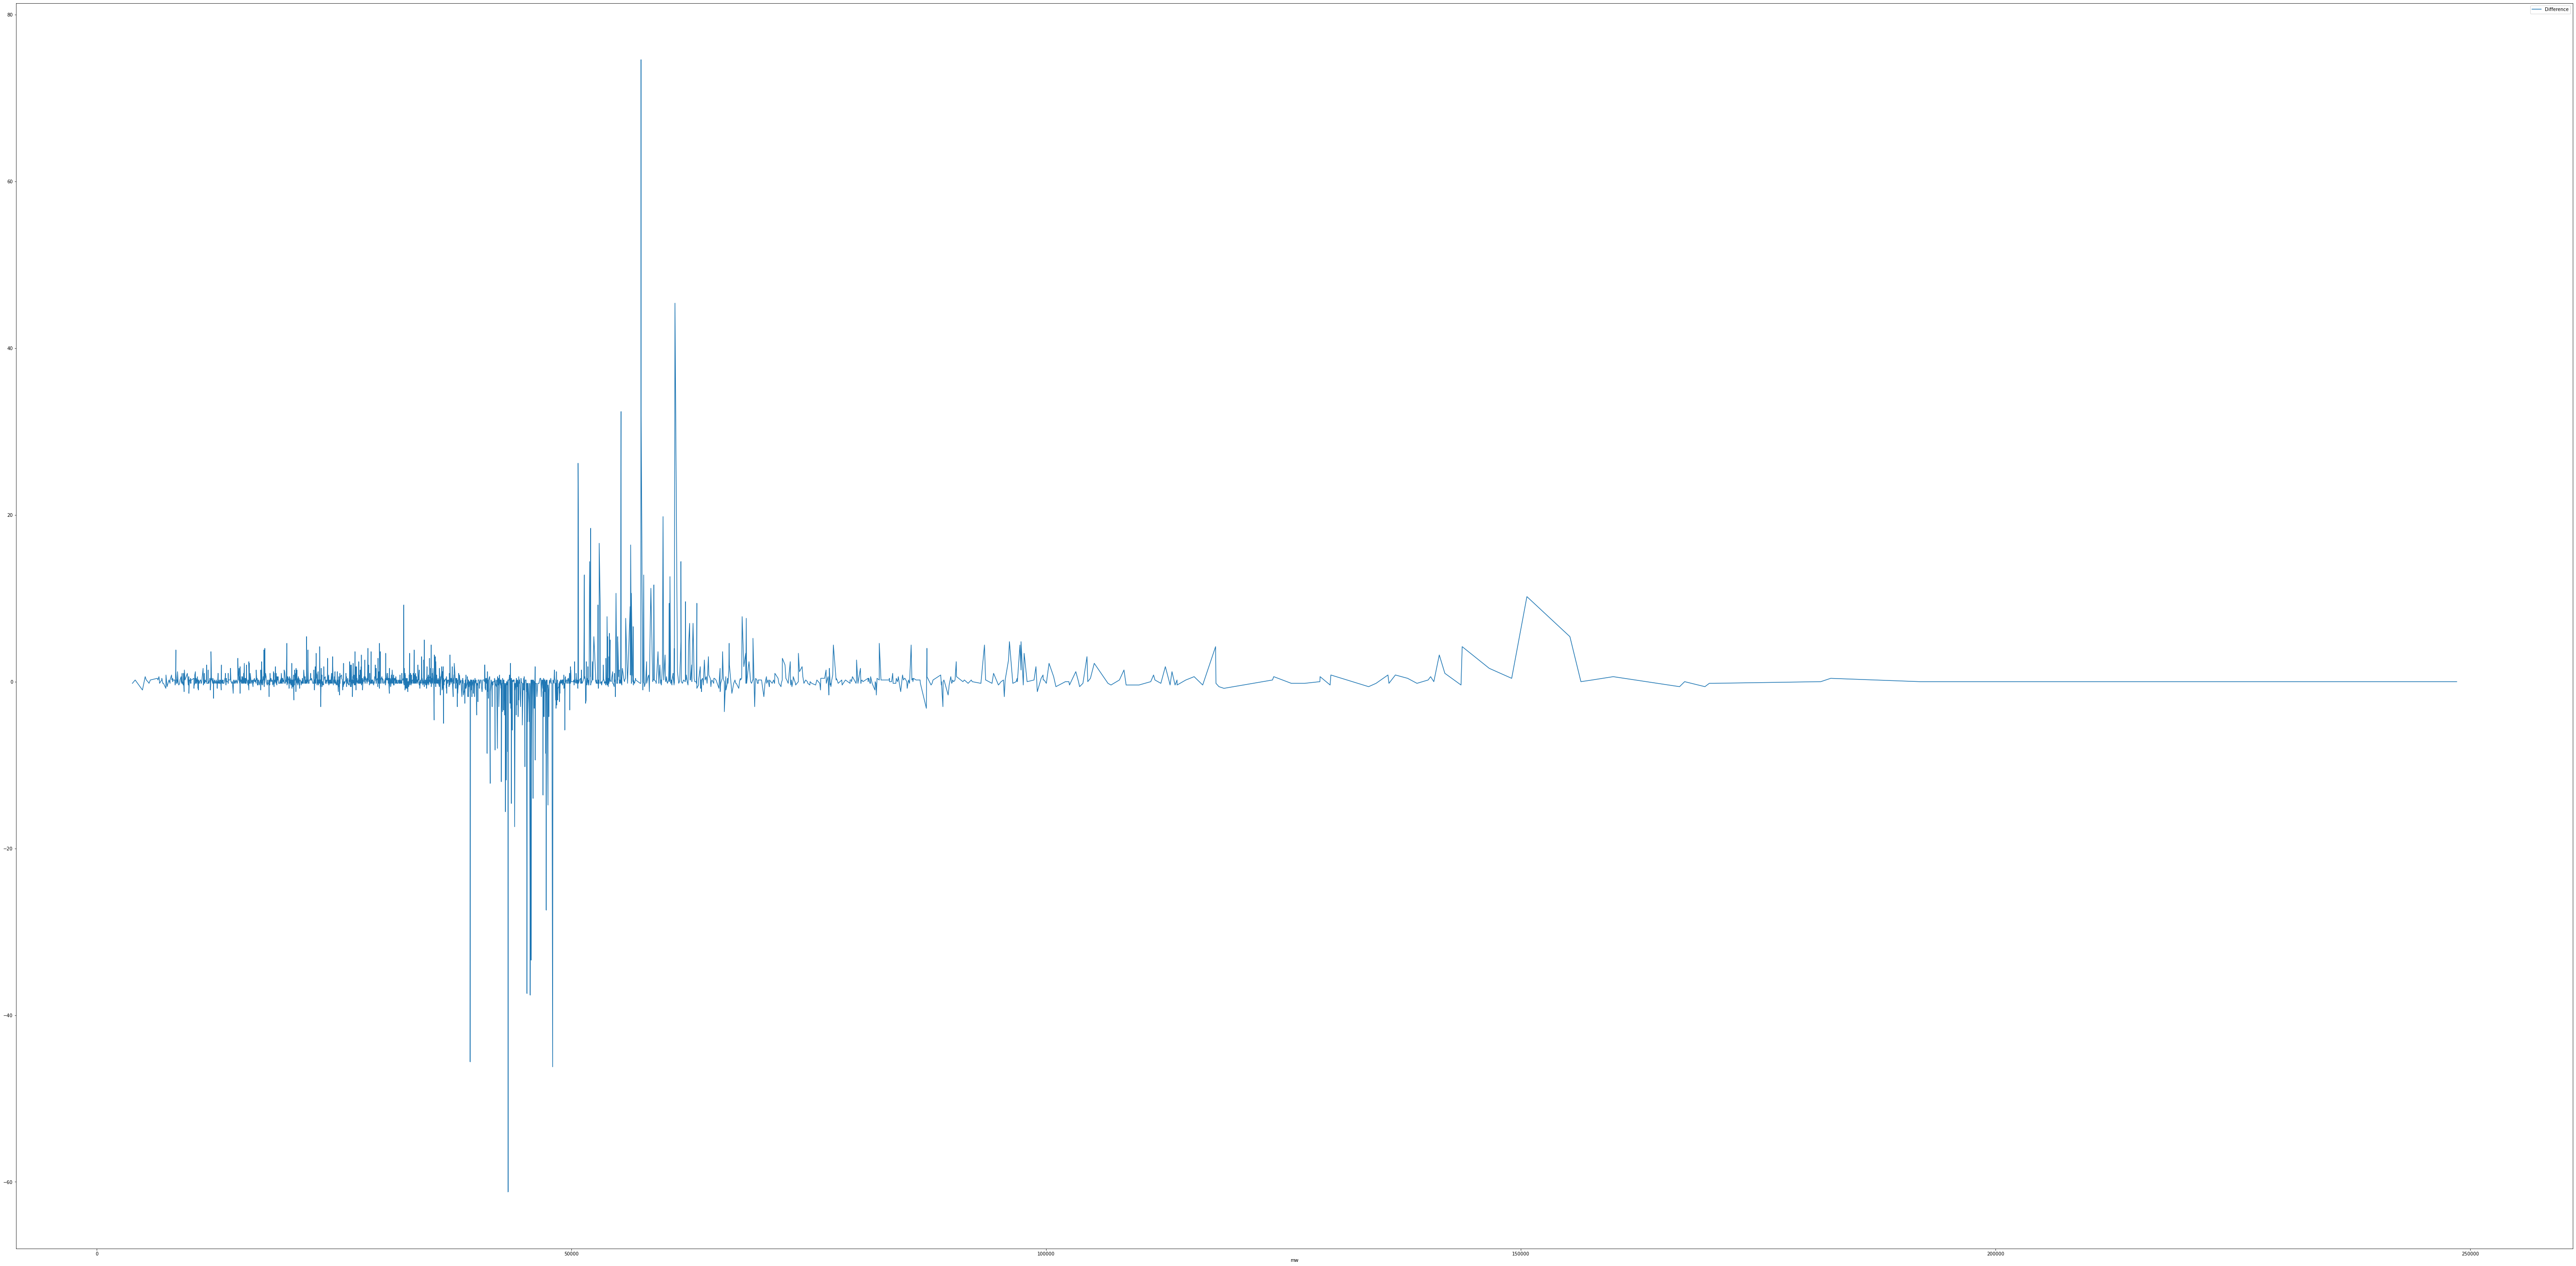

In [ ]:
red_yel_Diff_cm_cut = red_yel_Diff_c_copy.transpose().append(iPRG_MW.transpose()).dropna(axis = 1).transpose().set_index('mw')
red_yel_Diff_cm_cut.sort_index(inplace = True)

red_yel_Diff_cm_cut.plot()
plt.rcParams["figure.figsize"] = (100,50)
plt.show()

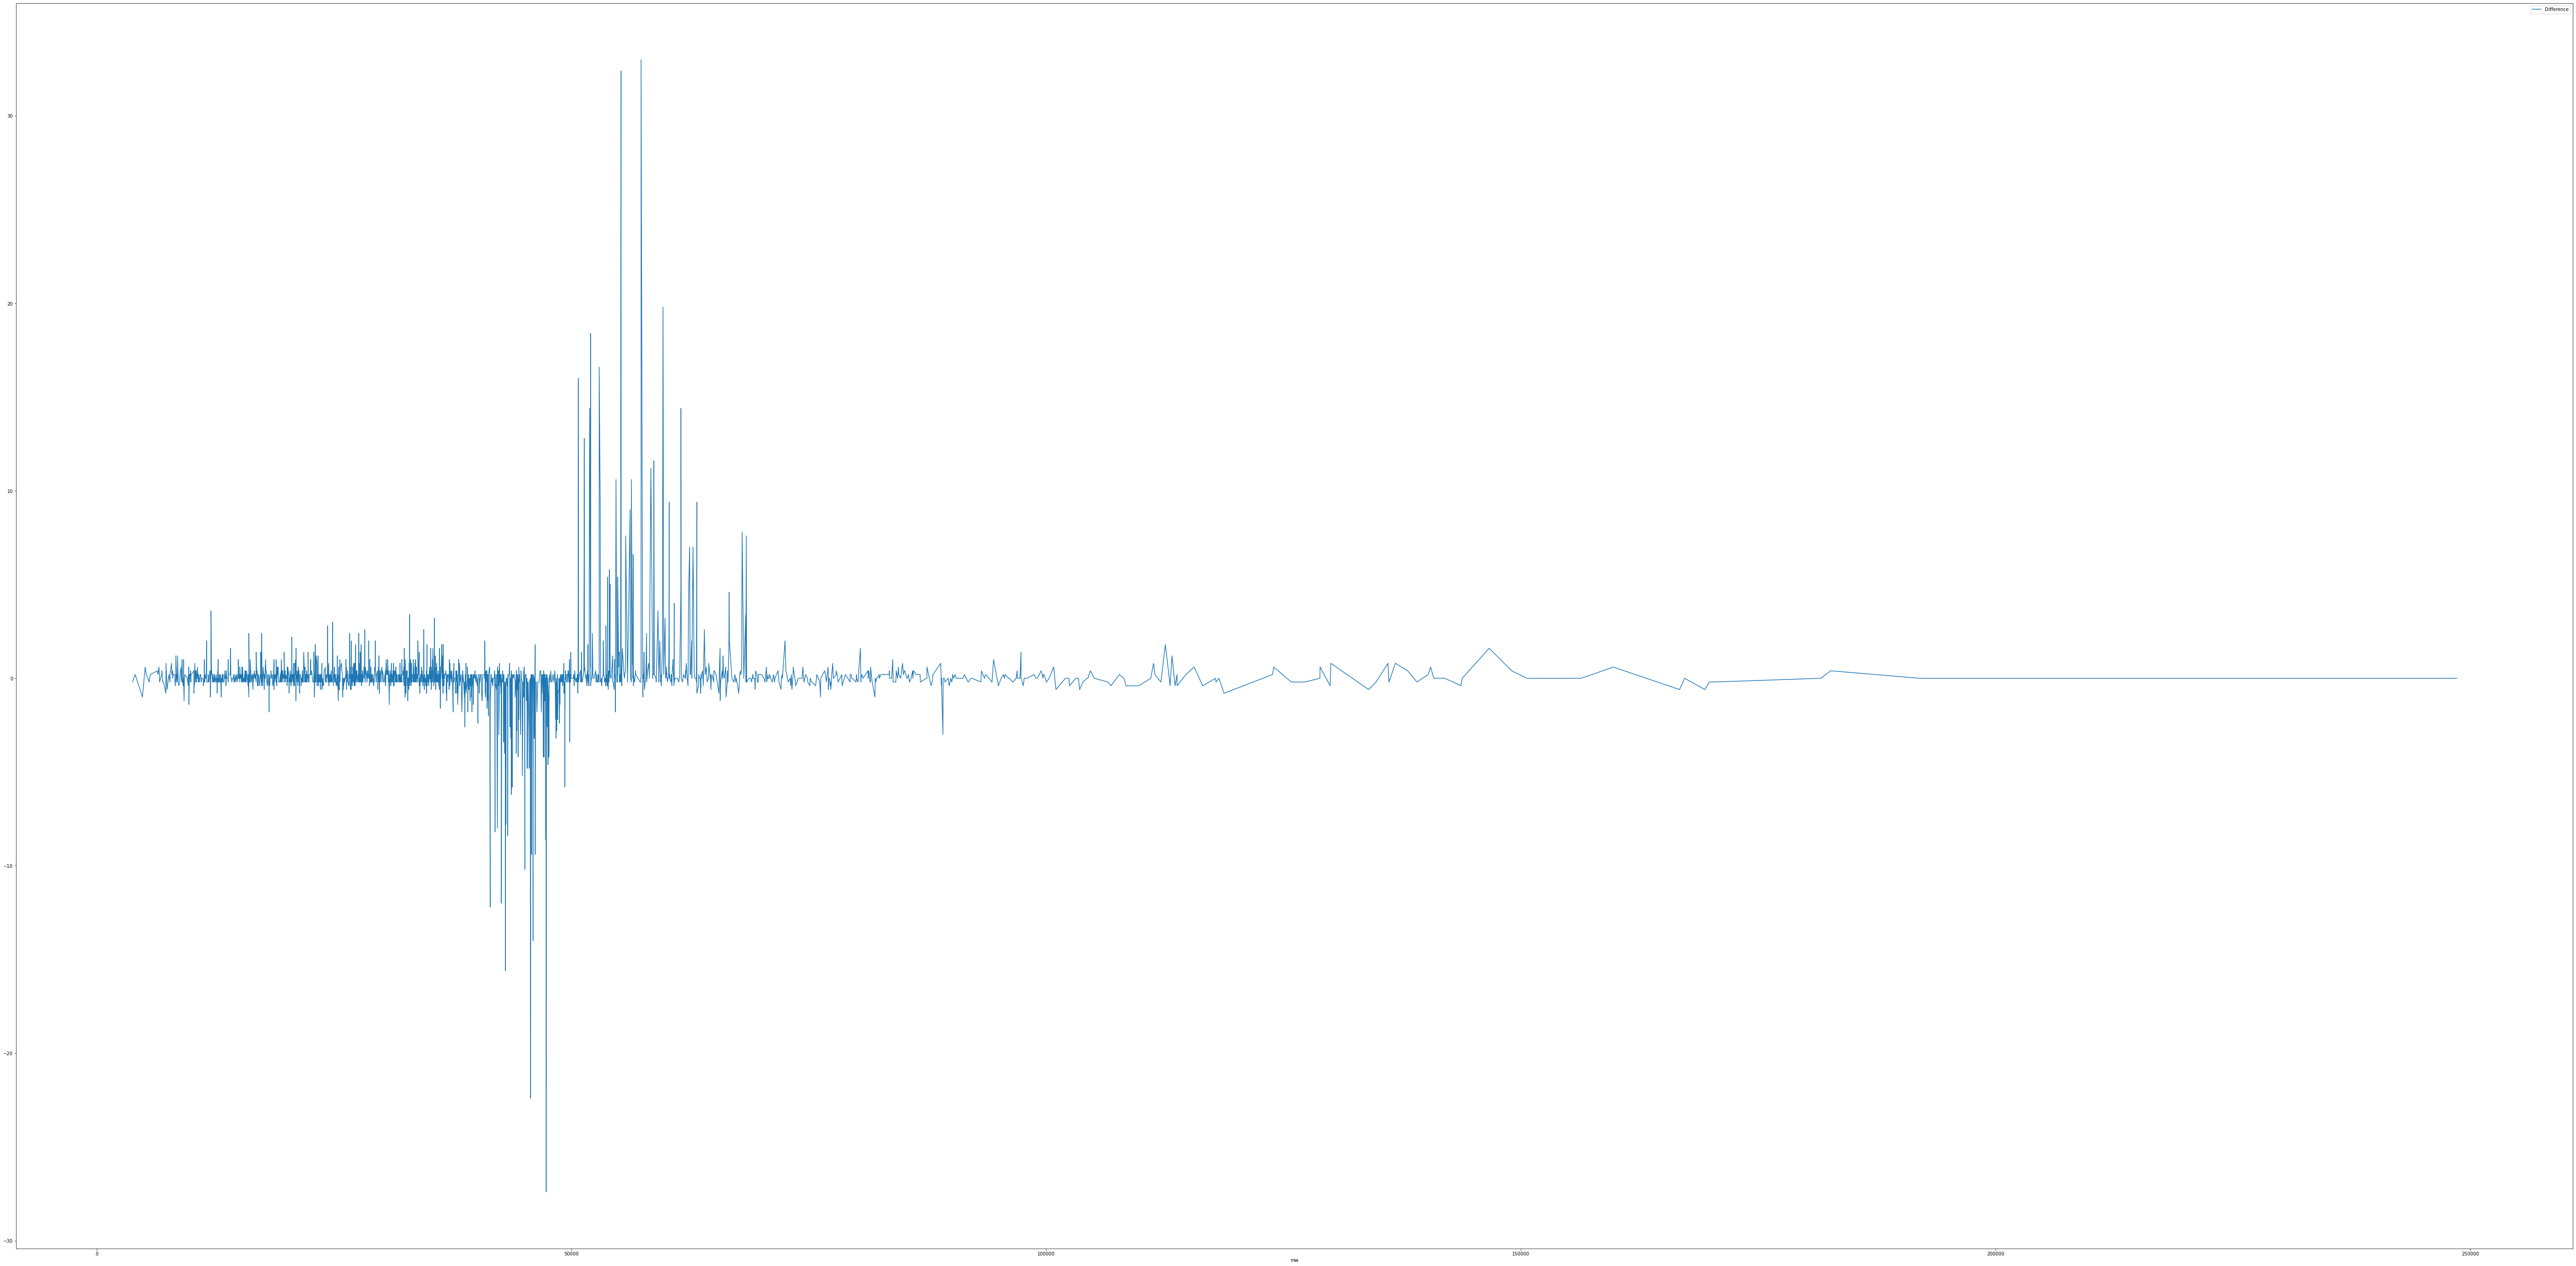

In [ ]:
red_yel_Diff_cm = red_yel_Diff_c.transpose().append(iPRG_MW.transpose()).dropna(axis = 1).transpose().set_index('mw')
red_yel_Diff_cm.sort_index(inplace = True)

red_yel_Diff_cm.plot()
plt.rcParams["figure.figsize"] = (100,50)
plt.show()

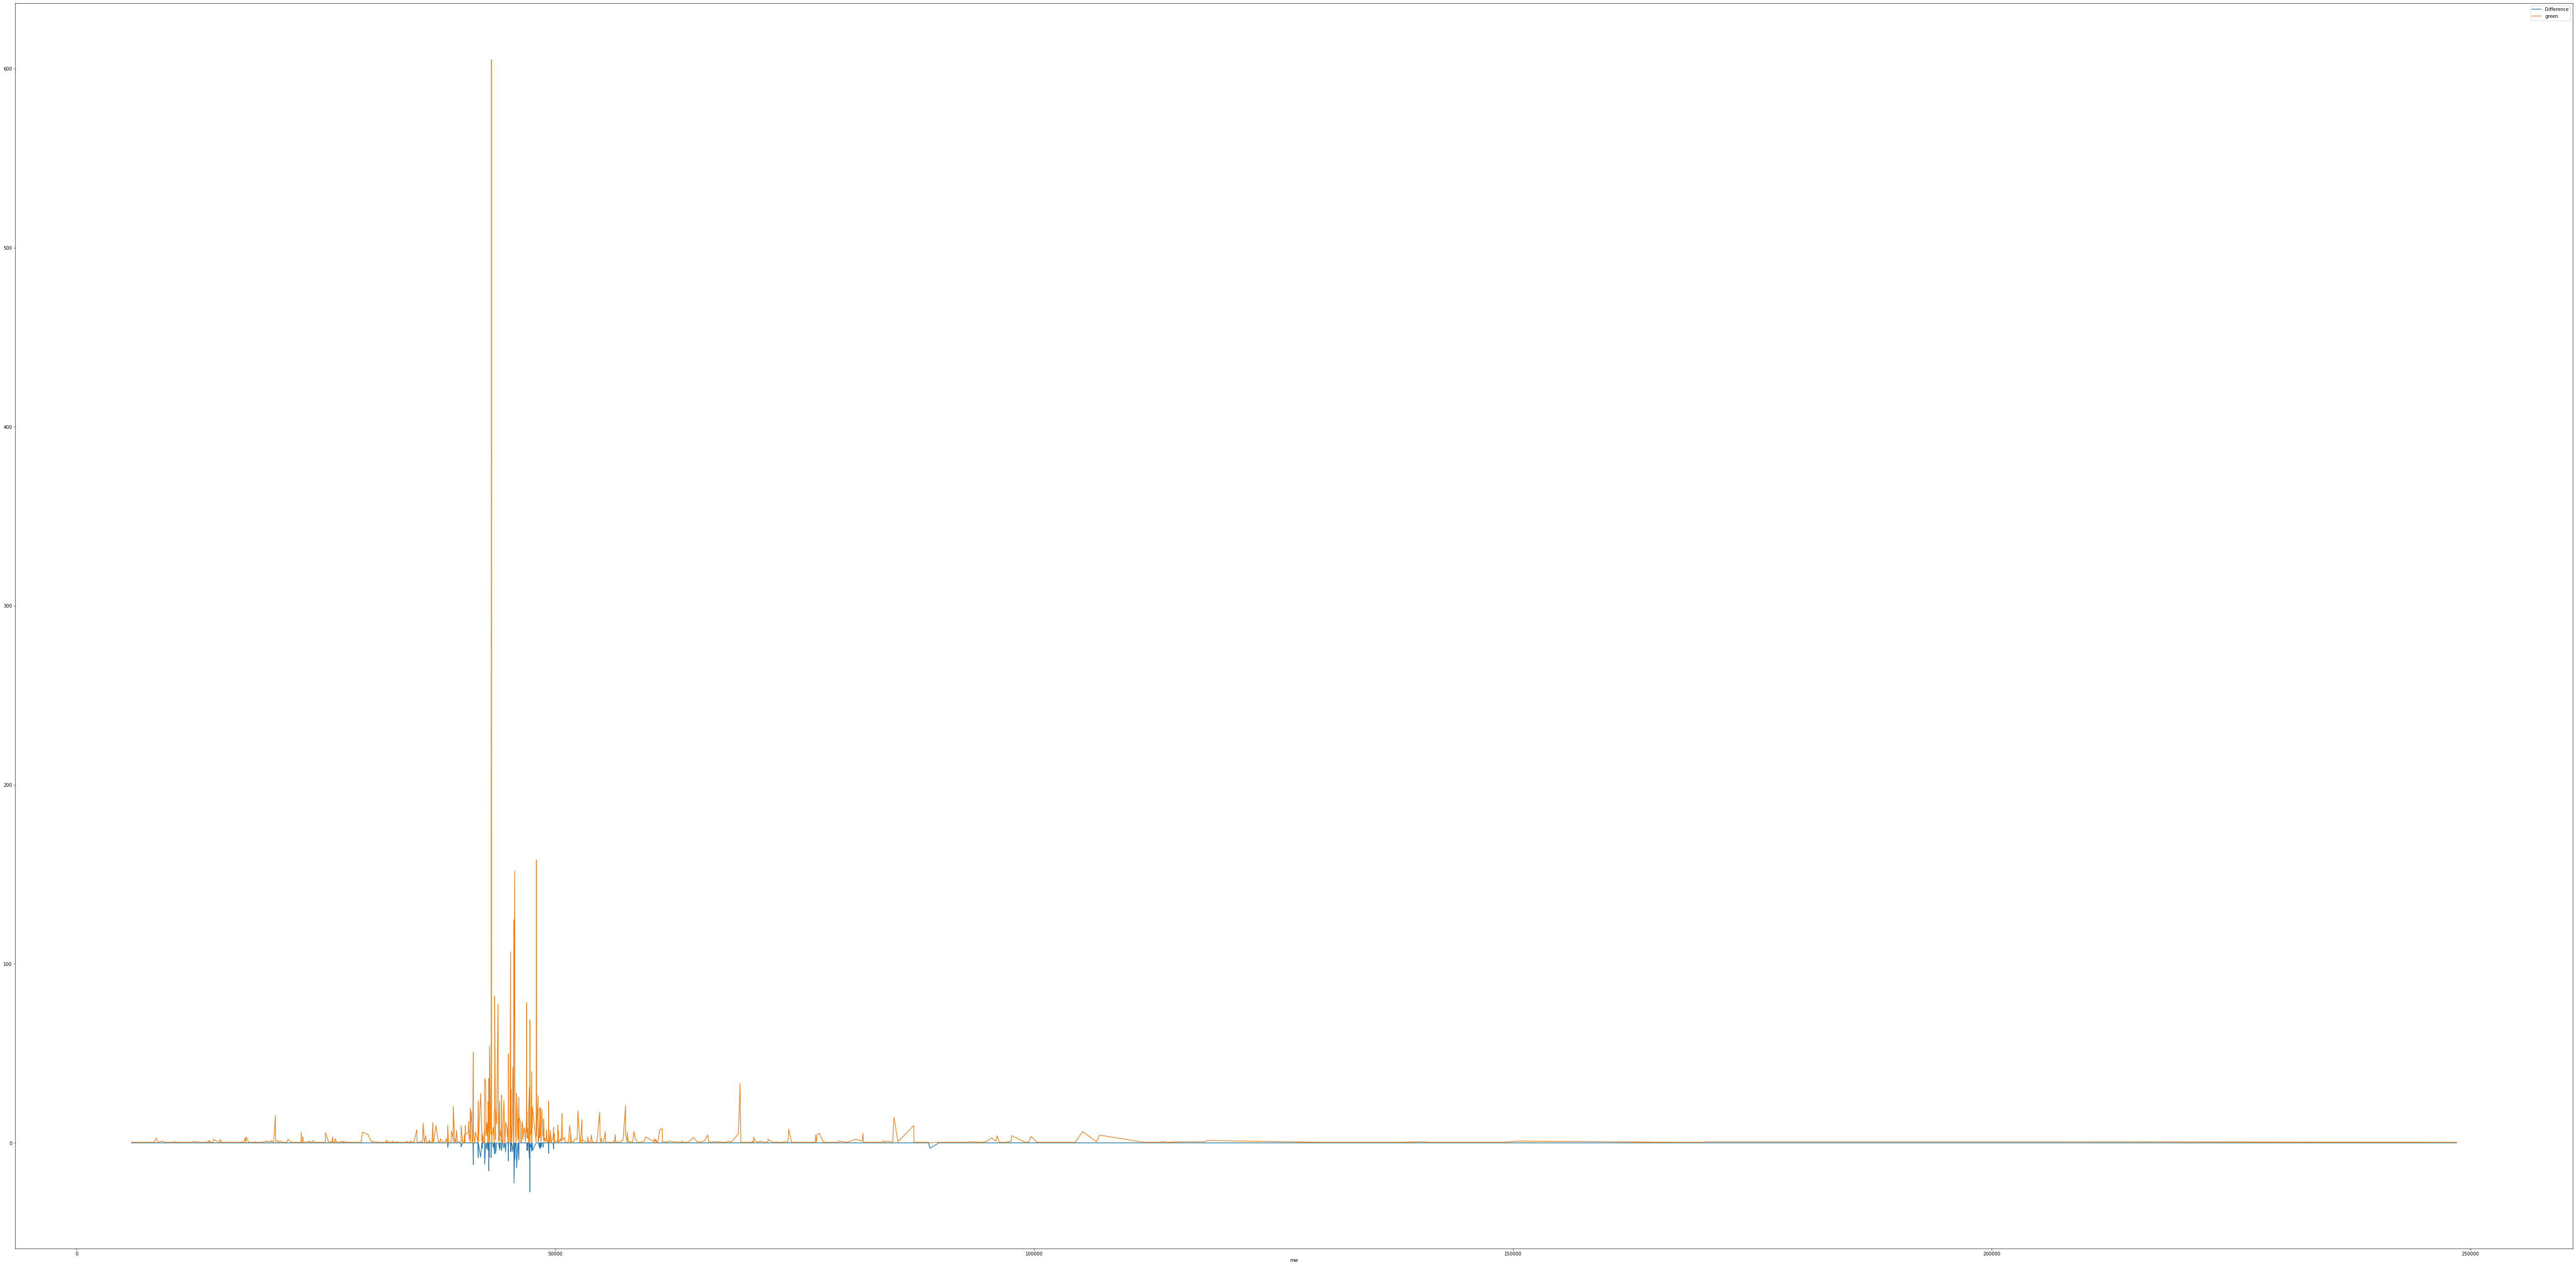

In [ ]:
Mean_Gcm_real = Mean_Gc.transpose().append(iPRG_MW.transpose()).dropna(axis = 1).transpose().set_index('mw').transpose()

gg_diff_cm = Mean_Gcm.append(Mean_Gcm_real).transpose()
gg_diff_cm.sort_index(inplace = True)
gg_diff_cm = gg_diff_cm.fillna(0)

gg_diff_cm.plot()
plt.rcParams["figure.figsize"] = (100,50)
plt.show()

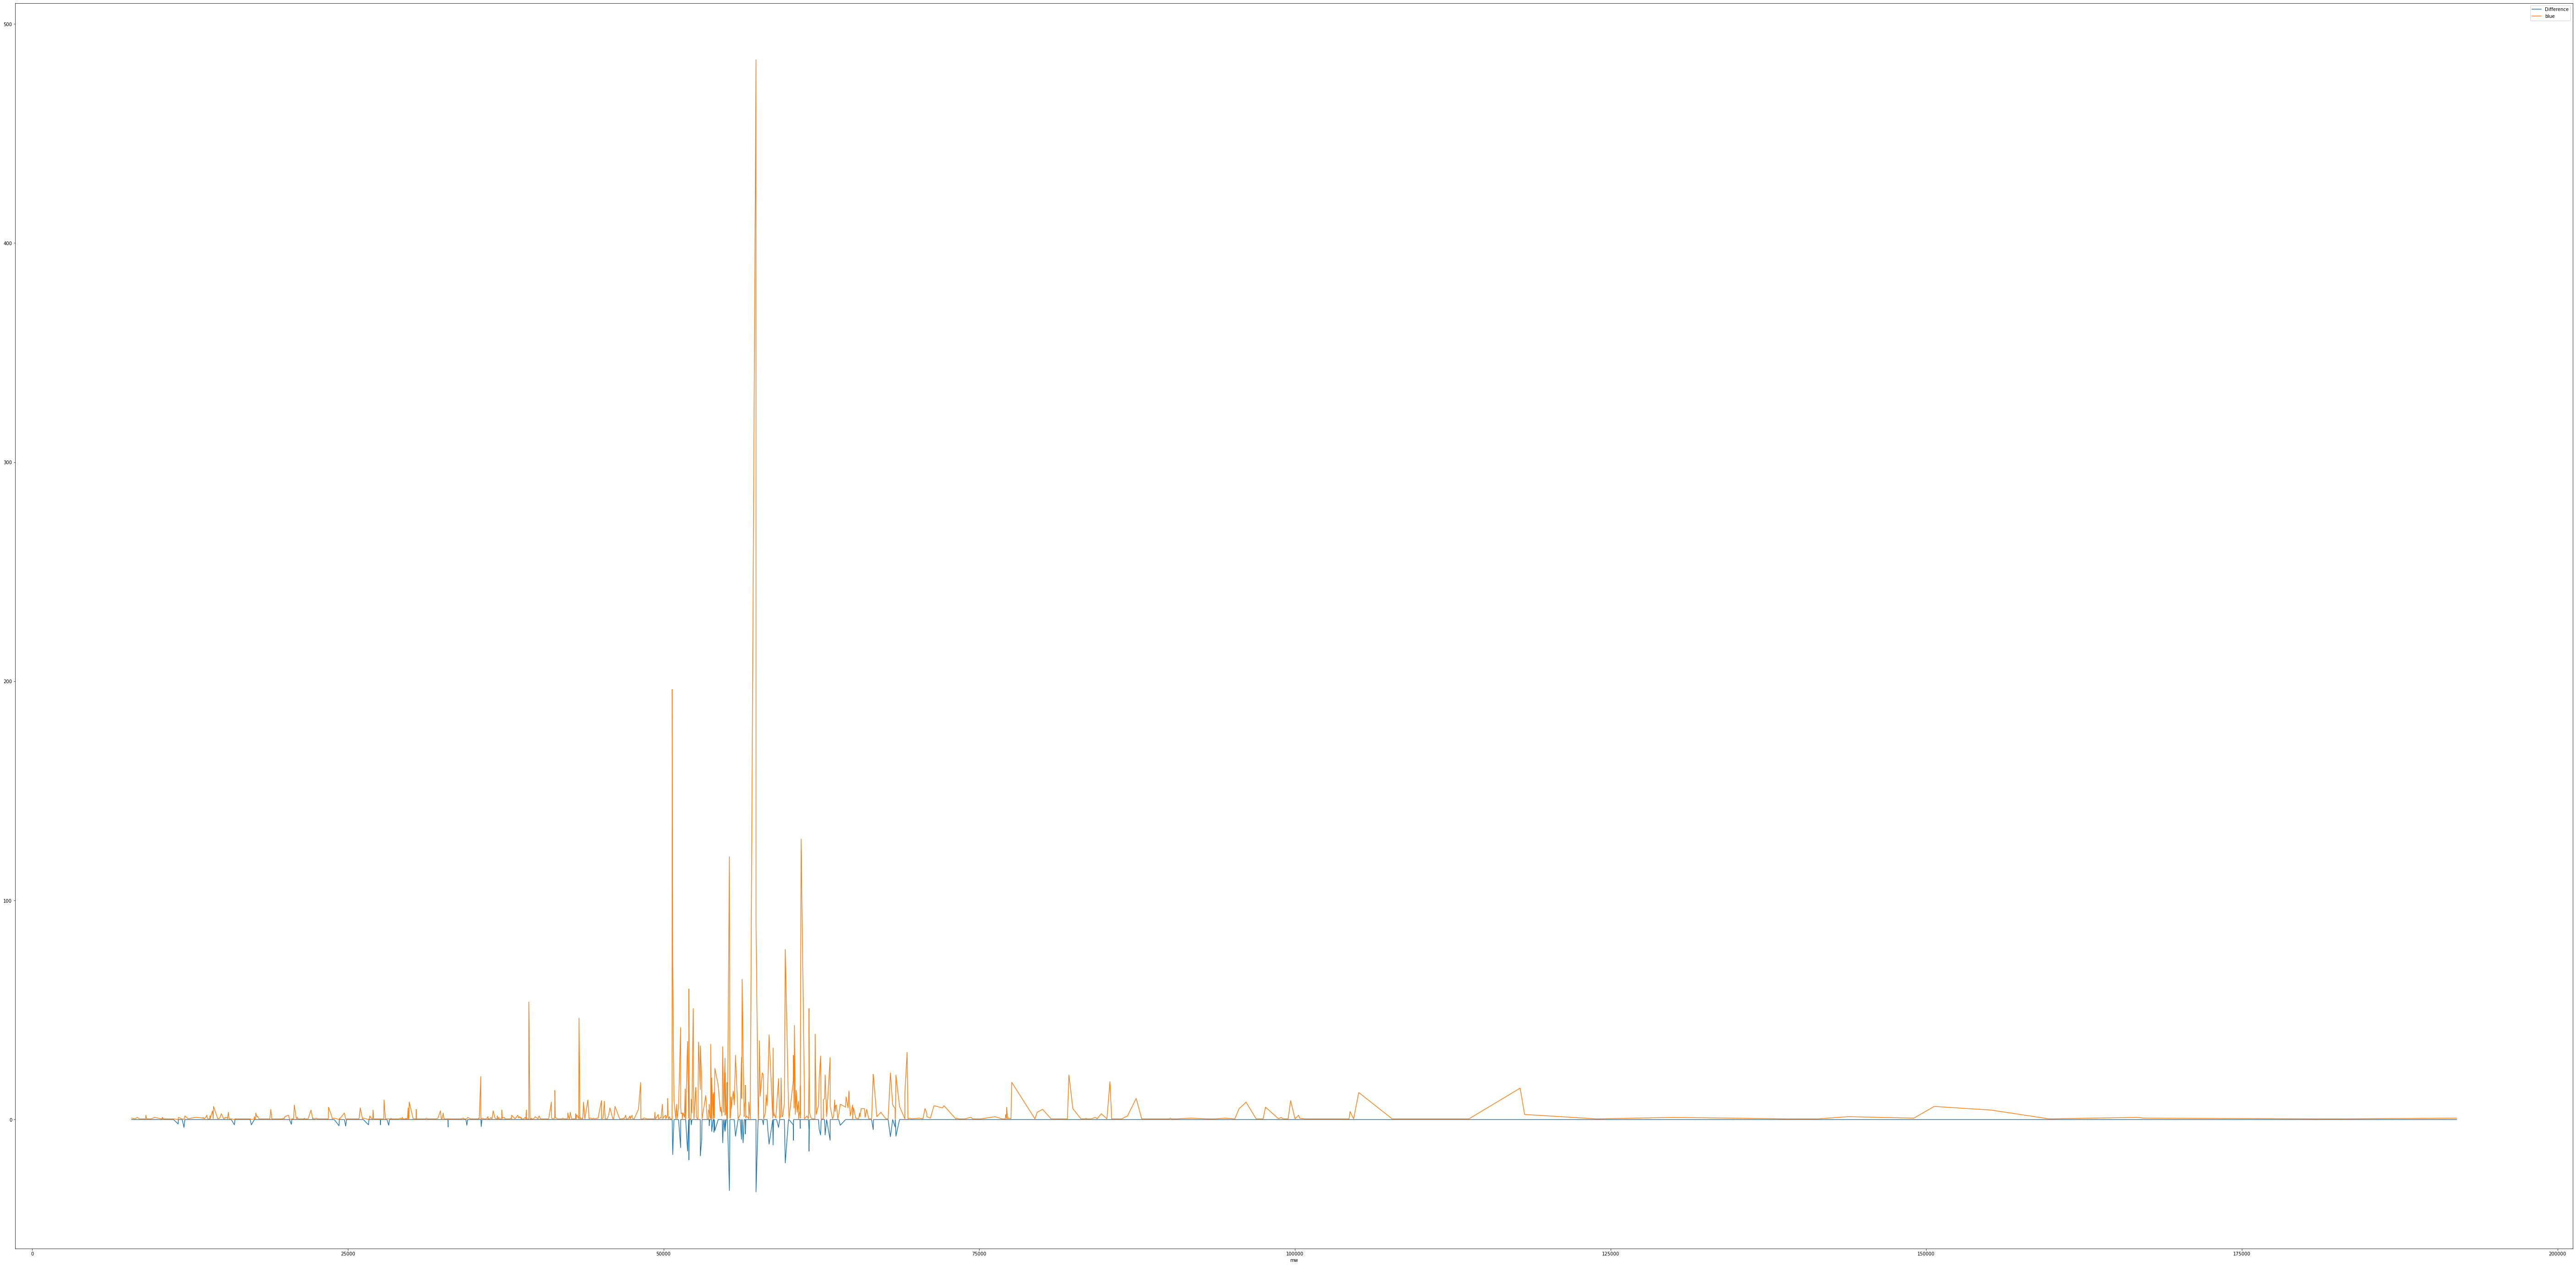

In [ ]:
Mean_Bcm_real = Mean_Bc.transpose().append(iPRG_MW.transpose()).dropna(axis = 1).transpose().set_index('mw').transpose()

bb_diff_cm = Mean_Bcm.append(Mean_Bcm_real).transpose()
bb_diff_cm.sort_index(inplace = True)
bb_diff_cm = bb_diff_cm.fillna(0)

bb_diff_cm.plot()
plt.rcParams["figure.figsize"] = (100,50)
plt.show()

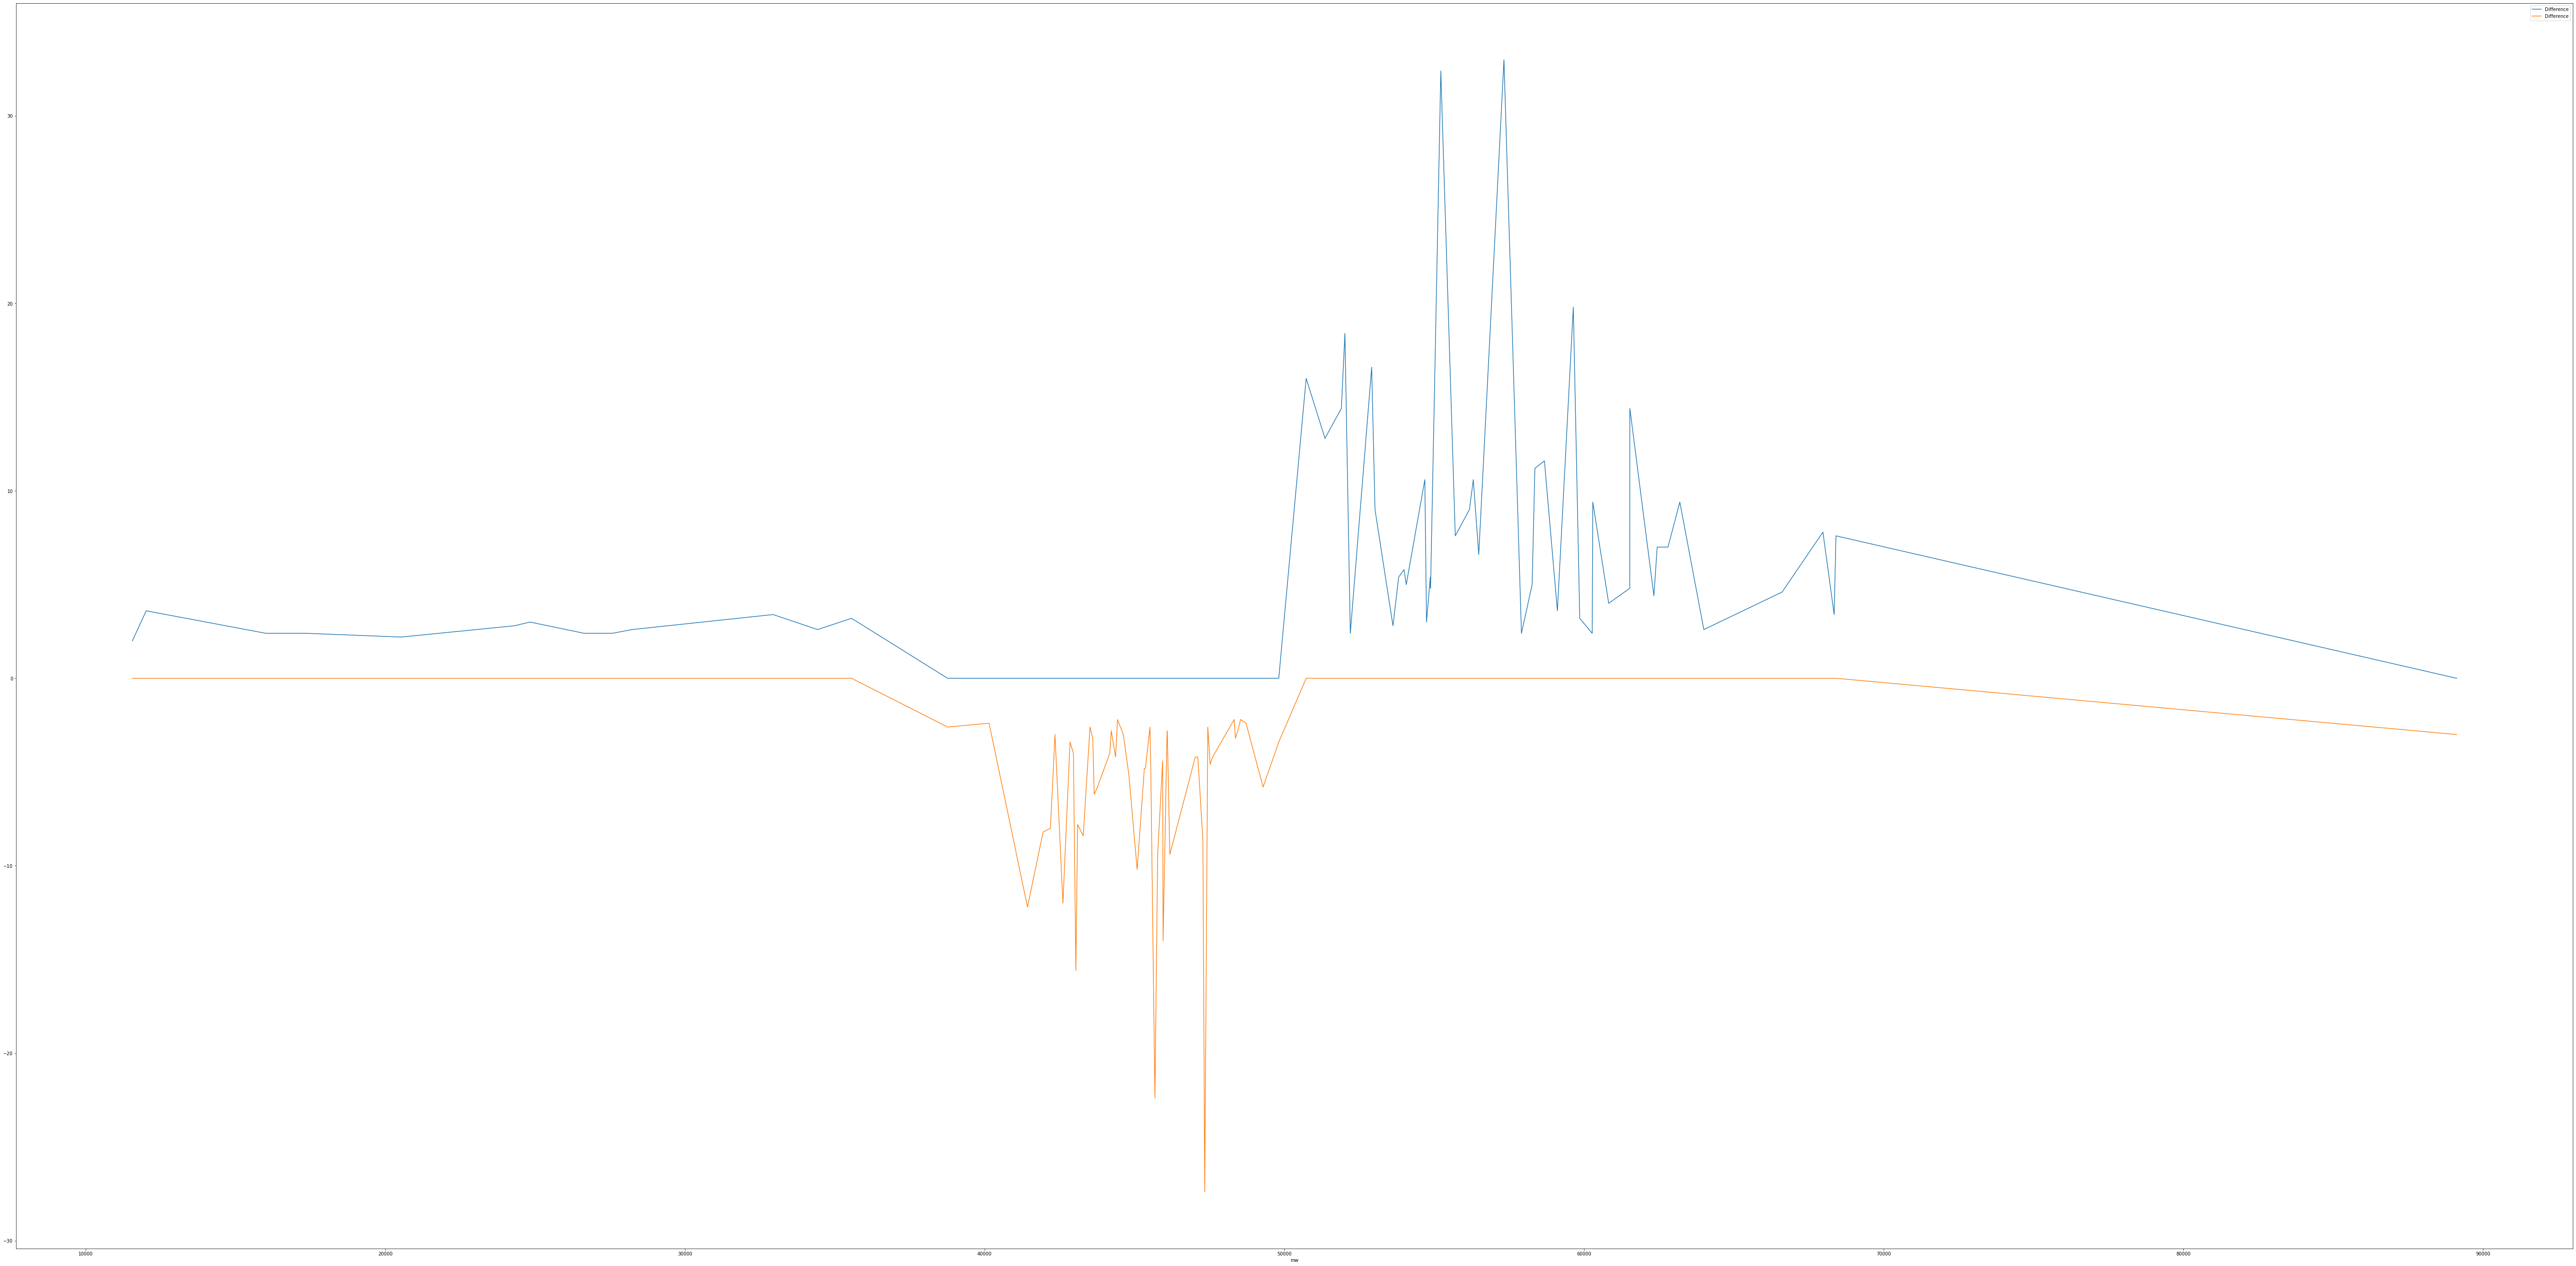

In [ ]:
Mean_GBc_mw = -Mean_Bcm.append(-Mean_Gcm).transpose()
Mean_GBc_mw = Mean_GBc_mw.fillna(0)

Mean_GBc_mw.plot()
plt.rcParams["figure.figsize"] = (100,50)
plt.show()

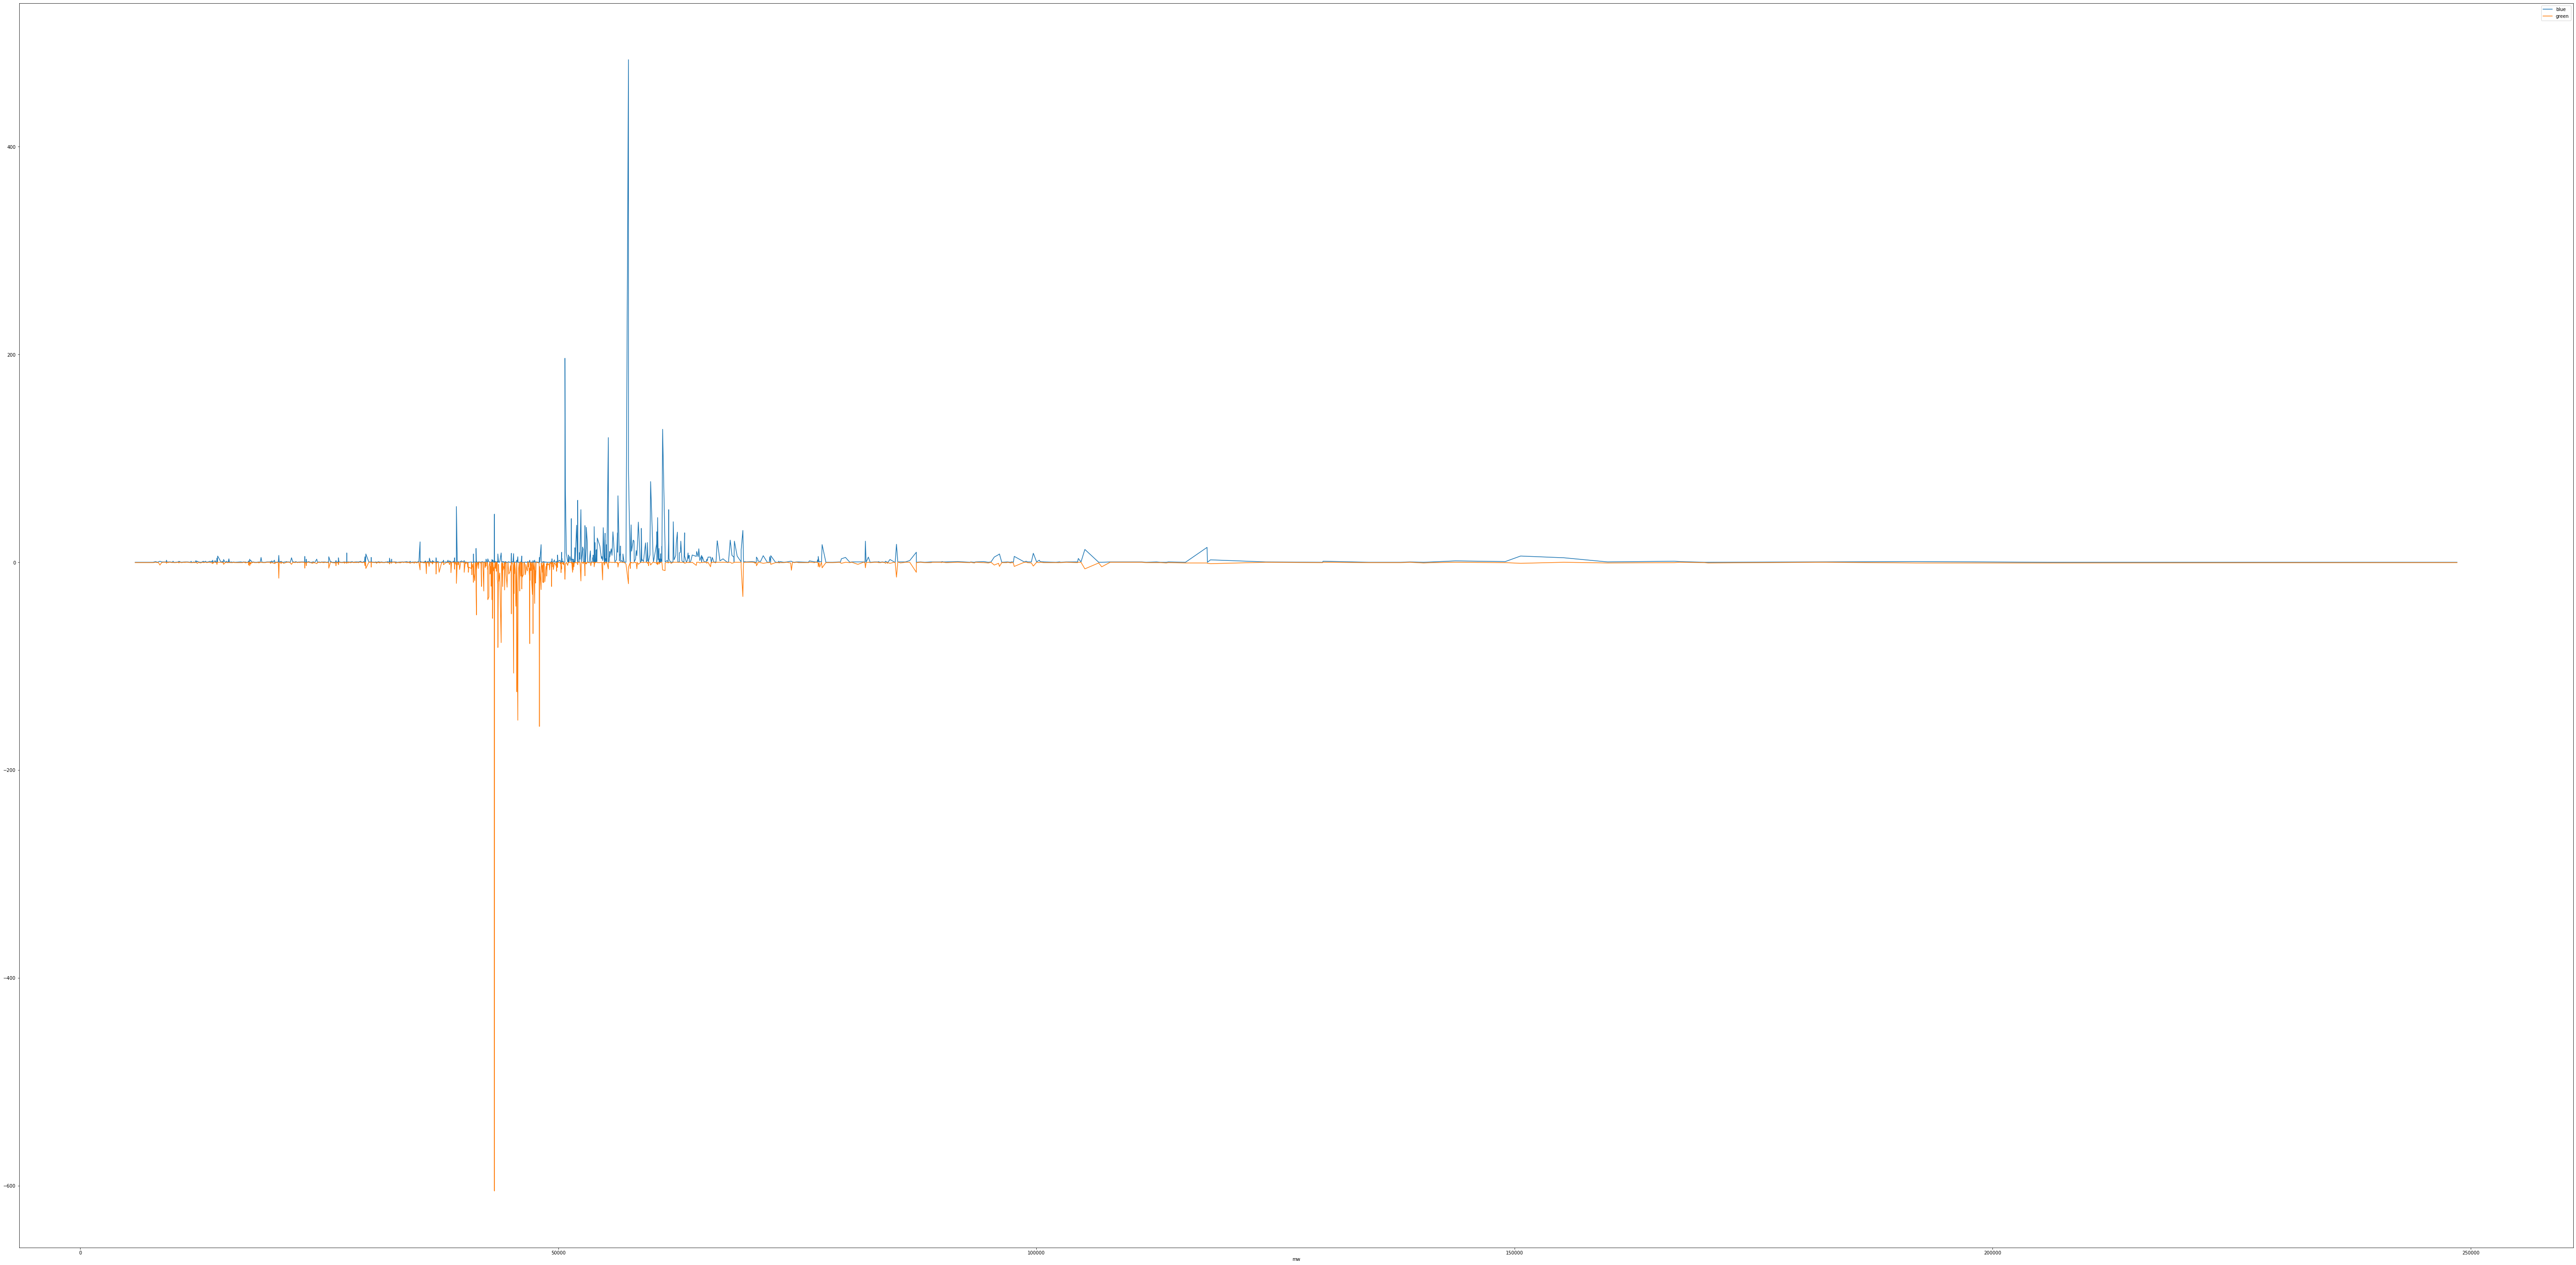

In [ ]:
bg_diff_cm = Mean_Bcm_real.append(-Mean_Gcm_real).transpose()
bg_diff_cm = bg_diff_cm.fillna(0)
bg_diff_cm.sort_index(inplace = True)

bg_diff_cm.plot()
plt.rcParams["figure.figsize"] = (100,50)
plt.show()

# MSGF

Colors = ['red', 'yellow', 'green', 'blue']
CNumber = [5,5,3,3]
Mean_RYm = df()
Mean_Gm = df()
Mean_Bm = df()

for order, color in enumerate(Colors):
    countdf = df()

    for i in range(1,CNumber[order]+1):
        data = []
        f = open("./iPRG2009_ECOLI_"+color+"_"+str(i)+".iPRG2009_Study.MSGF+.tsv", "rt")
        reader = csv.reader(f, delimiter='\t')
        data = list(reader)
        data_list = df(data[1:])
        data_list.columns = data[0]
        f.close()

        data_list = data_list.astype({'ScanNum':'int', 'Precursor':'float', 'DeNovoScore':'float', 'MSGFScore':'float', 'SpecEValue':'float', 'EValue':'float'}) 

        for i, p in enumerate(data_list['Protein']):
            data_list.loc[i, 'Protein'] = p[:p.find('(')]

        # mult = []
        # for p in data_list['Protein']:
        #     mult.append(p.find(';'))
        # data_list['isMulti'] = mult
        # data_list.drop(data_list[data_list['isMulti'] != -1].index, inplace = True)
        REV = []
        for p in data_list['Protein']:
            REV.append(p.find('rev_'))
        data_list['isRev'] = REV
        data_list.drop(data_list[data_list['isRev'] != -1].index, inplace = True)
        CNTM = []
        for p in data_list['Protein']:
            CNTM.append(p.find('Cntm_'))
        data_list['isCNTM'] = CNTM
        data_list.drop(data_list[data_list['isCNTM'] != -1].index, inplace = True)


        data_list.head()    

        data_cut = data_list[data_list['EValue'] < 0.05]
        data_group = data_cut.groupby('Protein')
        
        cnt = df(data_group.count().iloc[:,0]).transpose()
        cnt.index = [str(i)]
        if i == 1 : countdf = cnt
        else: countdf = countdf.append(cnt)
            
    countdf = countdf.fillna(0)
    if order == 0: Mean_RYm =  df(countdf.mean()).transpose()
    elif order == 1: Mean_RYm = Mean_RYm.append(df(countdf.mean()).transpose())
    elif order == 2: Mean_Gm = df(countdf.mean())
    elif order == 3: Mean_Bm = df(countdf.mean())
        
Mean_Gm.columns = ['green']
Mean_Bm.columns = ['blue']        

Mean_RYm = Mean_RYm.transpose().fillna(0)
Mean_RYm.columns = ['red', 'yellow']

red_yel_Diff_m = df(Mean_RYm['red']-Mean_RYm['yellow'])
red_yel_Diff_m.columns = ['Difference']

blue_estm = red_yel_Diff_m[red_yel_Diff_m['Difference'] > 2]
green_estm = red_yel_Diff_m[red_yel_Diff_m['Difference'] < -2]

green_truem = Mean_Gm[Mean_Gm['green'] > 1]
blue_truem = Mean_Bm[Mean_Bm['blue'] > 1]

list_blue_truem = list(blue_truem.index)
true_blue_cntm = 0;

for est in list(blue_estm.index):
    if est in list_blue_truem: true_blue_cntm += 1

print(true_blue_cntm)
print(len(blue_estm))
print(len(list_blue_truem))

list_green_truem = list(green_truem.index)
true_green_cntm = 0;

for est in list(green_estm.index):
    if est in list_green_truem: true_green_cntm += 1

print(true_green_cntm)
print(len(green_estm))
print(len(list_green_truem))

list_green_estm = list(green_truem.index)
overlap_cntm = 0;

for est in list(blue_truem.index):
    if est in list_green_estm: overlap_cntm += 1

print(overlap_cntm)

# TendemK

Colors = ['red', 'yellow', 'green', 'blue']
CNumber = [5,5,3,3]
Mean_RYt = df()
Mean_Gt = df()
Mean_Bt = df()

for order, color in enumerate(Colors):
    countdf = df()

    for i in range(1,CNumber[order]+1):
        data = []
        filename = "./iPRG2009_ECOLI_"+color+"_"+str(i)+".iPRG2009_Study.tandem.out.gz"
        f = gzip.open(filename, "rt")
        reader = csv.reader(f, delimiter='\t')
        data = list(reader)
        data_list = df(data)
        data_list.drop(columns=[1], inplace = True)
        f.close()

        data_want = []

        for line in data_list[0].tolist():
            if line is not None and '<group id=' in line:
                data_want.append(line)

        data_split = []

        for d in data_want:
            data_split.append(d.split('"'))

        ind = ['Protein', 'MW', 'Expect']
        data_interest = pd.DataFrame(columns = ind)

        for dat in data_split:
            app = {ind[0]:dat[11], ind[1]:dat[3], ind[2]:dat[9]}
            data_interest = data_interest.append(app, ignore_index = True)

        data_interest = data_interest.astype({'MW':'float', 'Expect':'float'}) 

        REV = []
        for p in data_interest['Protein']:
            REV.append(p.find('rev_'))
        data_interest['isRev'] = REV
        data_interest.drop(data_interest[data_interest['isRev'] != -1].index, inplace = True)
        CNTM = []
        for p in data_interest['Protein']:
            CNTM.append(p.find('Cntm_'))
        data_interest['isCNTM'] = CNTM
        data_interest.drop(data_interest[data_interest['isCNTM'] != -1].index, inplace = True)

        data_cut = data_interest[data_interest['Expect'] < 0.05]

        data_group = data_cut.groupby('Protein')

        cnt = df(data_group.count().iloc[:,0]).transpose()
        cnt.index = [str(i)]
        if i == 1 : countdf = cnt
        else: countdf = countdf.append(cnt)
            
    countdf = countdf.fillna(0)
    if order == 0: Mean_RYt =  df(countdf.mean()).transpose()
    elif order == 1: Mean_RYt = Mean_RYt.append(df(countdf.mean()).transpose())
    elif order == 2: Mean_Gt = df(countdf.mean())
    elif order == 3: Mean_Bt = df(countdf.mean())
        
Mean_Gt.columns = ['green']
Mean_Bt.columns = ['blue']        

Mean_RYt = Mean_RYt.transpose().fillna(0)
Mean_RYt.columns = ['red', 'yellow']

red_yel_Diff_t = df(Mean_RYt['red']-Mean_RYt['yellow'])
red_yel_Diff_t.columns = ['Difference']

blue_estt = red_yel_Diff_t[red_yel_Diff_t['Difference'] > 3]
green_estt = red_yel_Diff_t[red_yel_Diff_t['Difference'] < -3]

green_truet = Mean_Gt[Mean_Gt['green'] > 1]
blue_truet = Mean_Bt[Mean_Bt['blue'] > 1]

list_blue_truet = list(blue_truet.index)
true_blue_cntt = 0;

for est in list(blue_estt.index):
    if est in list_blue_truet: true_blue_cntt += 1

print(true_blue_cntt)
print(len(blue_estt))
print(len(list_blue_truet))

list_green_truet = list(green_truet.index)
true_green_cntt = 0;

for est in list(green_estt.index):
    if est in list_green_truet: true_green_cntt += 1

print(true_green_cntt)
print(len(green_estt))
print(len(list_green_truet))

list_green_estt = list(green_truet.index)
overlap_cntt = 0;

for est in list(blue_truet.index):
    if est in list_green_estt: overlap_cntt += 1

print(overlap_cntt)